# SVMのPythonによるフルスクラッチ実装

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## テスト用のデータを生成する

In [2]:
n_data0 = 50             #1.データの数
n_data1 = 50
n_data2 = 50

mean0 = [3, 4]          #2.データ０における平均値（ｘ、ｙ）
mean1 = [4, -2]
mean2 = [6, 3]


cov0  = [[1.0, 0.6],
         [0.6, 1.0]]    #3.データ０における共分散行列
cov1  = [[1.0, 0.0],
         [0.0, 1.0]]
cov2  = [[1.0, -0.6],
         [-0.6, 1.0]]


#二次元正規分布を生成する（0~3の値によって変動する）
label0 = np.random.multivariate_normal(mean0, cov0, n_data0)
label1 = np.random.multivariate_normal(mean1, cov1, n_data1)
label2 = np.random.multivariate_normal(mean2, cov2, n_data2)

#それぞれのデータの結合
X = np.concatenate((label0, label2, label1))
y = np.concatenate(((np.ones(n_data0+n_data2)), (np.ones(n_data1)*(-1)))).astype(int)

#np.random.seed(seed=0)
#順番を入れ替える
random_i = np.random.permutation(np.arange(n_data0+n_data1+n_data2))
X = X[random_i]
y = y[random_i]
len(y)

150

### matplotlibを使って図示する

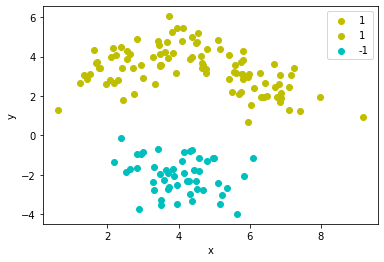

In [3]:
plt.scatter(label0[:,0],label0[:,1],c="y",label=1)
plt.scatter(label2[:,0],label2[:,1],c="y",label=1)
plt.scatter(label1[:,0],label1[:,1],c="c",label=-1)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

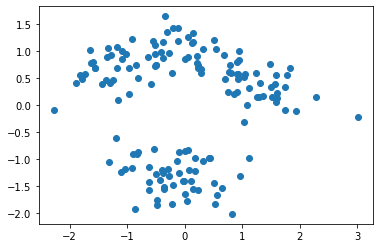

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

plt.scatter(X_std[:,0],X_std[:,1])
plt.show()

## SVMのフルスクラッチ実装(Hardmergin)

最適化手法のおさらい  
$$
\begin{align}
\mathrm{w} &=& \sum_{i = 1}^{N}\lambda_i y_i x_i  \\
b &=& \frac{1}{N} \sum_{i=1}^{N}(y_i-\sum_{j=1}^{n}(\lambda_i y_i x_i^T x_j)) \\
\lambda_i^{(n+1)} &=& \lambda_i^{(n)} + \alpha(1-\sum_{j=1}^{N} \lambda_j y_i y_j K(x_i,x_j))
\end{align}
$$
Kはカーネル法を使う場合に使用する


In [47]:
class SvmFullScratch:
    def __init__(self,iter_num=20,lr=1e-3,kernel='linear',gamma=0.5):
        self.iter_num = iter_num
        self._lr = lr
        self._kernel = kernel
        self.gamma = gamma
        self._sv = []
        self._y = []
        
    def _lagrange(self, X, y):
        y = y.reshape(-1,1)
        for i in range(len(X)):
            lam_sum = (self._lambda[i] * y[i] * y * self.kernel(X[i],X)).sum()
            self._lambda[i] += self._lr*(1-lam_sum)
            
            if self._lambda[i] < 0:
                self._lambda[i] = 0
                
    def fit(self, X, y):
        self._lambda = np.zeros((len(X),1))
        for i in range(self.iter_num):
            self._lagrange(X,y)
            
        index_sv = np.where(self._lambda > 0)[0]
        self._lambda = self._lambda[index_sv]
        self._sv = X[index_sv]
        self._y = y[index_sv]
    
    def kernel(self, xi, xj):
        if self._kernel == "linear":
            K = np.dot(xi.T,xj)
            return K
        elif self._kernel == "poly":
            d = 1
            r = 1
            K = (self.gamma*np.dot(xi.T,xj.T) + r)**d
            return K
        else:
            print("cannot found", self._kernel)
    
    def predict(self,X):
        y_hat = 0
        for i in range(len(self._sv)):
            y_hat += self._lambda[i] * self._y[i] * self.kernel(X.T, self._sv[i].T)
        return y_hat
            

In [9]:
from matplotlib.colors import ListedColormap

# 可視化関数
def plot_decision_regions(X, model):
    plt.scatter(X[:,0], X[:,1], s=80, c=y, marker='o')
    for sv in model._sv:
        plt.scatter(sv[0], sv[1], s=40, c='c', marker='o')
    
    step = 0.1
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-1.0, np.max(X[:,0])+1.0, step), np.arange(np.min(X[:,1])-1.0, np.max(X[:,1])+1.0, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)
    plt.contour(mesh_f0, mesh_f1, pred, 1)
    plt.show()

In [49]:
svm = SvmFullScratch(200, 1e-4,kernel="poly",gamma=2)
svm.fit(X_std, y)

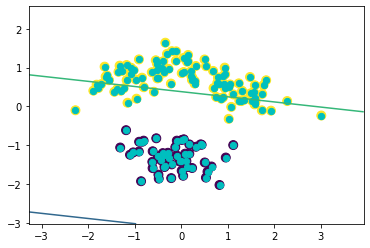

In [50]:
plot_decision_regions(X_std,svm)